In [10]:
import filecmp
import os
import subprocess
import tempfile

import librosa
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import pytest
import seaborn as sb
import tqdm

import keras

from keras.datasets import cifar10

%matplotlib inline

In [11]:
from keras import backend as K

from skimage.transform import  resize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

In [12]:
# This 26classes contains the unmodified pictures. we will test these pictures and obtian the accuracy
fileNames = os.listdir('Picture/New/26classes/modificationPictures/')
print(len(fileNames))

2442


In [13]:

# parentDir is the dictionary that store the spectrum pictures that will be modified

parentDir = './Picture/New/26classes/modificationPictures'
print(f'{parentDir}/{fileNames[0]}')

./Picture/New/26classes/modificationPictures/chainsaw#0284.png


In [14]:
# recording_name_list stores the relative dir of each picture, such as ''./Picture/New/26classes/modificationPictures/door_wood_knock-1442.png'
# nameClasses stores the class name of each picture, sucha as 'dog'
recording_name_list = []
nameClasses = []
for item in range(len(fileNames)):
    if fileNames[item].endswith('.png'):
        nameClasses.append(fileNames[item][:-9])        
        namedir = f'{parentDir}/{fileNames[item]}'
        recording_name_list.append(namedir)
print(len(recording_name_list),'\n', len(nameClasses))

2441 
 2441


chainsaw


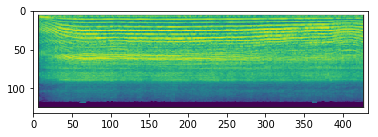

In [15]:
image = mpimg.imread(recording_name_list[0])
print(nameClasses[0])
plt.imshow(image)

In [80]:
# images is a list and  stores the matrix of each resized picture stored in parentDir

images = []
for i in range(len(recording_name_list)):
    
    img = mpimg.imread(recording_name_list[i])
    img = resize(img, (40,140))
    img = img[:,:,:3]
    images.append(img)  

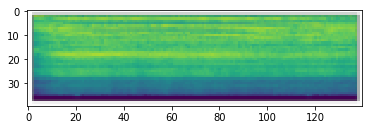

In [82]:
# image at position 0 after resizing
plt.imshow(images[0])


In [112]:
# X contains the data that will be used to classify
# nameClassesDF is a dataframe that contains the target of each picture in X
X = np.array(images)
print(X.shape)
nameClassesDF = pd.DataFrame(nameClasses, columns=['Name'])
print(nameClassesDF.shape)
input_shape = [40,140,3]
numberClasses = len(np.unique(nameClasses))
print('There are total :', numberClasses, ' classes')

(2441, 40, 140, 3)
(2441, 1)
There are total : 26  classes


In [113]:
nameClassesDF.head()

,Name
0,chainsaw
1,door_wood_knock
2,footsteps
3,door_wood_creaks
4,crying_baby


In [114]:
# make the targets into one-hot paternts and the name_mapping dictionary
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(nameClassesDF['Name'])
classes = le.transform(nameClassesDF['Name'])
name_mapping = dict(zip(le.transform(le.classes_),le.classes_))
print(name_mapping)

{0: 'airplane', 1: 'breathing', 2: 'brushing_teeth', 3: 'can_opening', 4: 'car_horn', 5: 'cat', 6: 'chainsaw', 7: 'chirping_birds', 8: 'church_bells', 9: 'clapping', 10: 'clock_alarm', 11: 'clock_tick', 12: 'coughing', 13: 'cow', 14: 'crackling_fire', 15: 'crickets', 16: 'crow', 17: 'crying_baby', 18: 'dog', 19: 'door_wood_creaks', 20: 'door_wood_knock', 21: 'drinking_sipping', 22: 'engine', 23: 'fireworks', 24: 'footsteps', 25: 'laughing'}


In [115]:
len(classes)

2441

In [116]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = classes.reshape(len(classes), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(max(integer_encoded))
print(onehot_encoded[0])

[25]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


/Users/zengxiangzhao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [117]:
# split the datasets into training set and test set
from sklearn.model_selection import train_test_split
y = onehot_encoded
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle = True, random_state=42)

### If I normalize the X, then the arhitecture will desn't work well. The accuracy will be below 0.05. But if I leave it along the architecture with Adam() optimizer has the best performace.


In [127]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(80, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(numberClasses, activation='softmax'))

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 38, 138, 32)       896       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 36, 136, 64)       18496     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 34, 134, 80)       46160     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 17, 67, 80)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 17, 67, 80)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 91120)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               11663488  
__________

### Accuracy of SGD is 0.2106 when epochs is 10

In [120]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.10, momentum=0.01, decay=0.005),     # others:  Adagrad(), Adadelta(), Adam()
              metrics=['accuracy'])

In [121]:
batch_size = 128

epochsM1 = 10

In [122]:
%%time

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochsM1,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1952 samples, validate on 489 samples
Epoch 1/10
1952/1952 [==============================] - 50s 25ms/step - loss: 3.2517 - acc: 0.0553 - val_loss: 3.2162 - val_acc: 0.0859
Epoch 2/10
1952/1952 [==============================] - 41s 21ms/step - loss: 3.1979 - acc: 0.0697 - val_loss: 3.0972 - val_acc: 0.1002
Epoch 3/10
1952/1952 [==============================] - 41s 21ms/step - loss: 3.1565 - acc: 0.1009 - val_loss: 2.9888 - val_acc: 0.1186
Epoch 4/10
1952/1952 [==============================] - 43s 22ms/step - loss: 3.0461 - acc: 0.1071 - val_loss: 3.1003 - val_acc: 0.1125
Epoch 5/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.9671 - acc: 0.1358 - val_loss: 2.9032 - val_acc: 0.1472
Epoch 6/10
1952/1952 [==============================] - 41s 21ms/step - loss: 2.8571 - acc: 0.1578 - val_loss: 2.7169 - val_acc: 0.2086
Epoch 7/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.7300 - acc: 0.2013 - val_loss: 2.6328 - val_acc: 0.2229
E

### The model 1 with SGD optimizer is improved after increasing the datasets, The former accuracy is about 0.0385. And now it is about 0.1(when epoch is 3/10).

In [132]:
# model1 is the same as the above model beside the optimizer which is replaced with Adam optimizer
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model1.add(Conv2D(64, (3, 3), activation='relu'))

model1.add(Conv2D(80, (3, 3), activation='relu'))

model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))

model1.add(Dropout(0.5))

model1.add(Dense(numberClasses, activation='softmax'))

In [133]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 38, 138, 32)       896       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 36, 136, 64)       18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 34, 134, 80)       46160     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 67, 80)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 17, 67, 80)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 91120)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               11663488  
__________

In [134]:
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),     # others:  Adagrad(), Adadelta(), Adam()
              metrics=['accuracy'])

In [135]:
%%time

model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochsM1,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1952 samples, validate on 489 samples
Epoch 1/10
1952/1952 [==============================] - 47s 24ms/step - loss: 3.2863 - acc: 0.0748 - val_loss: 3.0743 - val_acc: 0.1370
Epoch 2/10
1952/1952 [==============================] - 43s 22ms/step - loss: 3.0430 - acc: 0.1112 - val_loss: 2.8544 - val_acc: 0.1636
Epoch 3/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.8978 - acc: 0.1522 - val_loss: 2.7317 - val_acc: 0.1943
Epoch 4/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.7893 - acc: 0.1660 - val_loss: 2.6204 - val_acc: 0.3170
Epoch 5/10
1952/1952 [==============================] - 44s 23ms/step - loss: 2.6141 - acc: 0.2310 - val_loss: 2.4604 - val_acc: 0.3354
Epoch 6/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.5085 - acc: 0.2433 - val_loss: 2.3033 - val_acc: 0.3517
Epoch 7/10
1952/1952 [==============================] - 43s 22ms/step - loss: 2.3472 - acc: 0.2997 - val_loss: 2.2031 - val_acc: 0.4049
E

In [137]:
# Adam optimizer
score1 = model1.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score1[0])

print('Test accuracy:', score1[1])

489/489 [==============================] - 3s 7ms/step
Test loss: 1.8866648715454133
Test accuracy: 0.43762781234850423


In [138]:
# SGD optimizer
score1 = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score1[0])

print('Test accuracy:', score1[1])

489/489 [==============================] - 4s 7ms/step
Test loss: 3.257338188908583
Test accuracy: 0.026584867075664622


### Let's try another model model2, which is a modification of LeNet-5 architecture. The former accuracy after 20 epochs is about 0.5.

In [139]:
# LeNet-5 architecture modification
model2 = Sequential()
model2.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(filters=24, kernel_size = (5,5), strides=1, padding='valid', activation='relu'))

model2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding='valid'))

model2.add(Conv2D(filters = 48, kernel_size = (5,5), strides = 1, padding = 'valid', activation='relu'))
model2.add(Dropout(0.5))

model2.add(Flatten())

model2.add(Dense(units =128, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(numberClasses, activation = 'softmax'))

In [140]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 38, 138, 12)       336       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 34, 134, 24)       7224      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 17, 67, 24)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 13, 63, 48)        28848     
_________________________________________________________________
dropout_26 (Dropout)         (None, 13, 63, 48)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 39312)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               5032064   
__________

In [141]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),     
              metrics=['accuracy'])

In [142]:
batch_size = 128

epochsM2 = 10

### Actually the epochs is 20, I execute the following command 2 times. The accuracy of the model is 0.57, with a increasement of 0.07.

In [143]:
%%time

model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochsM2,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1952 samples, validate on 489 samples
Epoch 1/10
1952/1952 [==============================] - 33s 17ms/step - loss: 3.2041 - acc: 0.0697 - val_loss: 2.9880 - val_acc: 0.1104
Epoch 2/10
1952/1952 [==============================] - 31s 16ms/step - loss: 3.0380 - acc: 0.0953 - val_loss: 2.8770 - val_acc: 0.1268
Epoch 3/10
1952/1952 [==============================] - 31s 16ms/step - loss: 2.9027 - acc: 0.1281 - val_loss: 2.8057 - val_acc: 0.1616
Epoch 4/10
1952/1952 [==============================] - 30s 15ms/step - loss: 2.7898 - acc: 0.1685 - val_loss: 2.5431 - val_acc: 0.2556
Epoch 5/10
1952/1952 [==============================] - 30s 15ms/step - loss: 2.6422 - acc: 0.2075 - val_loss: 2.5668 - val_acc: 0.2045
Epoch 6/10
1952/1952 [==============================] - 30s 15ms/step - loss: 2.5480 - acc: 0.2234 - val_loss: 2.4454 - val_acc: 0.3129
Epoch 7/10
1952/1952 [==============================] - 29s 15ms/step - loss: 2.3465 - acc: 0.2915 - val_loss: 2.2378 - val_acc: 0.3497
E

In [144]:
t = model2.predict(X_test[4].reshape(-1,40,140,3))
cls = np.argmax(t)

print(cls)
print('Predict class is :',name_mapping[cls])
print("Original class is :",np.argmax(y_test[4] ))

12
Predict class is : coughing
Original class is : 12


In [146]:
t = model2.predict(X_test[1].reshape(-1,40,140,3))
cls = np.argmax(t)

print(cls)
print('Predict class is :',name_mapping[cls])
print("Original class is :",np.argmax(y_test[1] ))

24
Predict class is : footsteps
Original class is : 24


In [147]:
t = model2.predict(X_test[20].reshape(-1,40,140,3))
cls = np.argmax(t)

print(cls)
print('Predict class is :',name_mapping[cls])
print("Original class is :",np.argmax(y_test[20] ))

19
Predict class is : door_wood_creaks
Original class is : 1


In [148]:
# Modification of google architecture
model3 = Sequential()

model3.add(Conv2D(12, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model3.add(Conv2D(12, (3, 3), activation='relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(24, (3, 3), activation='relu'))
model3.add(Conv2D(24, (3, 3), activation='relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(48, (3, 3), activation='relu'))
model3.add(Conv2D(48, (3, 3), activation='relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(96, activation='relu'))

model3.add(Dropout(0.5))

model3.add(Dense(numberClasses, activation='softmax'))

In [149]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 38, 138, 12)       336       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 36, 136, 12)       1308      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 18, 68, 12)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 16, 66, 24)        2616      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 14, 64, 24)        5208      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 7, 32, 24)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 5, 30, 48)         10416     
__________

In [150]:
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),     
              metrics=['accuracy'])

In [151]:
batch_size = 128

epochsM3 = 10

### It seems like the model3 is a better model, because there are few parameters than the former two models. And the accracy is very close to the second model.

In [152]:
%%time

model3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochsM3,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1952 samples, validate on 489 samples
Epoch 1/10
1952/1952 [==============================] - 18s 9ms/step - loss: 3.2407 - acc: 0.0487 - val_loss: 3.1786 - val_acc: 0.0736
Epoch 2/10
1952/1952 [==============================] - 14s 7ms/step - loss: 3.1680 - acc: 0.0686 - val_loss: 3.0843 - val_acc: 0.0818
Epoch 3/10
1952/1952 [==============================] - 14s 7ms/step - loss: 3.0989 - acc: 0.0850 - val_loss: 2.9754 - val_acc: 0.1043
Epoch 4/10
1952/1952 [==============================] - 14s 7ms/step - loss: 3.0096 - acc: 0.1045 - val_loss: 2.8369 - val_acc: 0.1943
Epoch 5/10
1952/1952 [==============================] - 14s 7ms/step - loss: 2.8972 - acc: 0.1260 - val_loss: 2.7746 - val_acc: 0.1963
Epoch 6/10
1952/1952 [==============================] - 14s 7ms/step - loss: 2.8002 - acc: 0.1501 - val_loss: 2.6132 - val_acc: 0.2658
Epoch 7/10
1952/1952 [==============================] - 14s 7ms/step - loss: 2.6999 - acc: 0.1921 - val_loss: 2.5173 - val_acc: 0.2904
Epoch 8/

### Conclusion: Adam optimizer is better than SGD optimizer. Increasing the databates by flipping the original pictures can not  increase the accuracy of the model-1 and model-2. The accuracy of model-3 is increased by 0.05. This is maybe that we can't only bye flipping the pictures to enlarge the size of the dataset.